In [197]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D
from keras.layers import LSTM
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt

In [198]:
df = pd.read_csv('CleanIMDB_train.csv') # Windows single-byte character encoding
df.head()

,review,sentiment
0,steve carell stars person relate to sort of da...,1
1,found enjoyable muppets movie felt light heart...,1
2,altogether bad start program slap face real la...,0
3,saw film tonight nyc landmark sunshine did not...,1
4,much like japanese movies one did not cut it m...,0


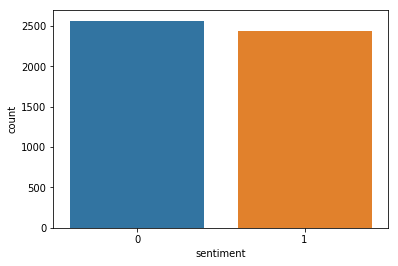

In [199]:
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
sns.countplot(x='sentiment', data=df)

In [200]:
X = df.iloc[:, 0].values
y = df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [201]:
# Use only thirty percent of the dataset for Keras -1500
# X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,y_train,test_size=0.20, random_state=42)

In [202]:
tokenizer = Tokenizer(num_words=5000)
# Vocabulary index based on word index frequency - fit_on_texts
# Every word gets unique integer value - word_index["the"] = 1; word_index["cat"] = 2
tokenizer.fit_on_texts(X_train)
# texts_to_sequences - transforms each text in texts to a sequence of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [203]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
# 0 is reserved for padding when more than 100 words length on each sample
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [204]:
# print(X_train)

In [205]:
# Downloaded the GloVe embeddings "glove.68.zip" and use 100d - pre-trained word vectors
# Load the embeddings file: source - https://nlp.stanford.edu/projects/glove/
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [206]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [207]:
# print(embedding_matrix)

In [222]:
# Simple Neural Network - densely connected neural network
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [223]:
print(vocab_size)

34468


In [224]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 10001     
Total params: 3,456,801
Trainable params: 10,001
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [245]:
history = model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.6416 - acc: 0.6353 - val_loss: 0.5798 - val_acc: 0.7075
Epoch 2/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.4919 - acc: 0.8069 - val_loss: 0.5250 - val_acc: 0.7638
Epoch 3/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.4039 - acc: 0.8694 - val_loss: 0.4855 - val_acc: 0.7862
Epoch 4/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3421 - acc: 0.8972 - val_loss: 0.4895 - val_acc: 0.7625
Epoch 5/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.2967 - acc: 0.9156 - val_loss: 0.4504 - val_acc: 0.7987
Epoch 6/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.2472 - acc: 0.9463 - val_loss: 0.4430 - val_acc: 0.8112
Epoch 7/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.2168 - acc: 0.9613 - val_loss: 0.4365 - val_acc: 0.8100
Epoch 8/12
3200

In [246]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 1s 842us/step


In [247]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.40701492309570314
Test Accuracy: 0.8220000267028809


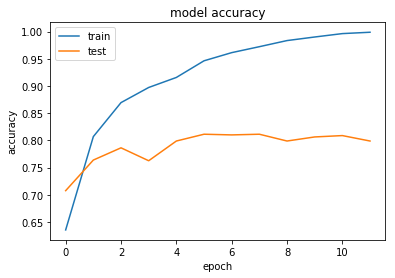

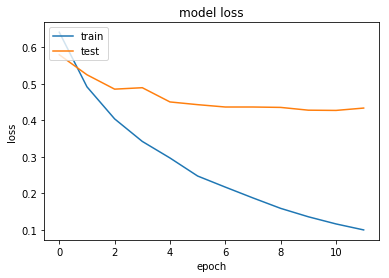

In [248]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [249]:
# 1D Convolutional Neural Network for feature extraction and 1 pooling layer
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [250]:
print(model.summary())

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 3,511,057
Trainable params: 64,257
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [251]:
history = model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.6666 - acc: 0.6000 - val_loss: 0.5970 - val_acc: 0.6800
Epoch 2/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.5105 - acc: 0.7750 - val_loss: 0.5406 - val_acc: 0.7425
Epoch 3/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.4234 - acc: 0.8478 - val_loss: 0.4994 - val_acc: 0.7738
Epoch 4/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3599 - acc: 0.8928 - val_loss: 0.4730 - val_acc: 0.7937
Epoch 5/12
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3127 - acc: 0.9156 - val_loss: 0.4614 - val_acc: 0.7925
Epoch 6/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.2730 - acc: 0.9366 - val_loss: 0.4494 - val_acc: 0.7975
Epoch 7/12
3200/3200 [==============================] - 6s 2ms/step - loss: 0.2360 - acc: 0.9550 - val_loss: 0.4444 - val_acc: 0.7962
Epoch 8/12
3200

In [252]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4081892099380493
Test Accuracy: 0.8199999928474426


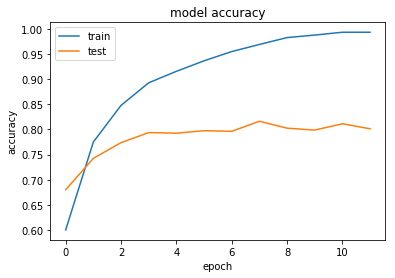

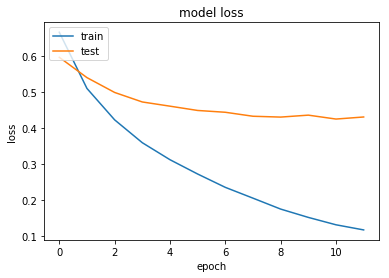

In [253]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [254]:
# Recurrent Neural Network with LSTM (Long Short Term Memory Network) a variant of RNN with 128 neurons
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [255]:
print(model.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 3,564,177
Trainable params: 117,377
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [256]:
history = model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/12
3200/3200 [==============================] - 24s 7ms/step - loss: 0.6774 - acc: 0.5503 - val_loss: 0.6846 - val_acc: 0.5875
Epoch 2/12
3200/3200 [==============================] - 22s 7ms/step - loss: 0.6147 - acc: 0.6856 - val_loss: 0.5719 - val_acc: 0.7200
Epoch 3/12
3200/3200 [==============================] - 21s 7ms/step - loss: 0.5626 - acc: 0.7319 - val_loss: 0.5512 - val_acc: 0.7200
Epoch 4/12
3200/3200 [==============================] - 23s 7ms/step - loss: 0.6213 - acc: 0.6816 - val_loss: 0.5883 - val_acc: 0.7188
Epoch 5/12
3200/3200 [==============================] - 24s 7ms/step - loss: 0.5335 - acc: 0.7494 - val_loss: 0.5037 - val_acc: 0.7775
Epoch 6/12
3200/3200 [==============================] - 23s 7ms/step - loss: 0.4977 - acc: 0.7725 - val_loss: 0.4942 - val_acc: 0.7825
Epoch 7/12
3200/3200 [==============================] - 23s 7ms/step - loss: 0.4691 - acc: 0.7856 - val_loss: 0.4612 - val_acc: 0.7925
Epoch 8/

In [257]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.47740601253509524
Test Accuracy: 0.7919999957084656


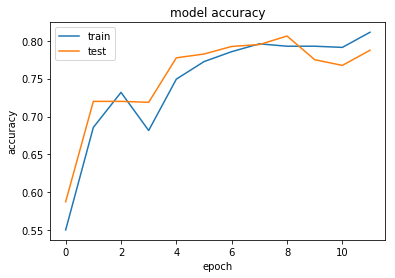

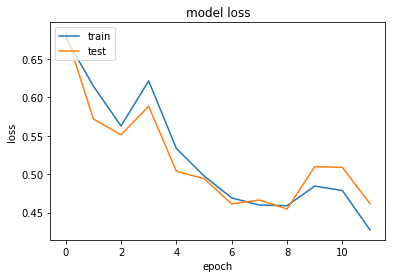

In [258]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()